In [1]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import torch
import pandas as pd
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch import Tensor
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision.io import read_image
from torchvision.transforms import v2, Lambda

In [3]:
# Extract the image tar files
#!tar -xf "/content/drive/MyDrive/Graduation Project/AffectNet/train_images.tar" -C "/content/"
#!tar -xf "/content/drive/MyDrive/Graduation Project/AffectNet/val_images.tar" -C "/content/"
#!tar -xf "/content/drive/MyDrive/Graduation Project/AffectNet/test_images.tar" -C "/content/"

# Define train data path
train_annotations = "/content/drive/MyDrive/Graduation Project/AffectNet/train_annotations.csv"
train_images = "/content/train_images"

# Define test data path
val_annotations = "/content/drive/MyDrive/Graduation Project/AffectNet/val_annotations.csv"
val_images = "/content/val_images"

# Define test data path
test_annotations = "/content/drive/MyDrive/Graduation Project/AffectNet/test_annotations.csv"
test_images = "/content/test_images"

In [36]:
class AffectNet(Dataset):
    """
    A Dataset subclass for handling the AffectNet dataset.

    Attributes:
        annotations (DataFrame): The annotations for the images.
        root_dir (str): The root directory where the images are stored.
        transform (callable, optional): Optional transform to be applied on an image.
    """

    def __init__(self, annotations_file, img_root_dir, transform=None):
        """
        Initializes the AffectNet dataset.

        Args:
            annotations_file (str): The path to the CSV file containing the annotations.
            img_root_dir (str): The root directory where the images are stored.
            transform (callable, optional): Optional transform to be applied on an image.
        """

        self.annotations = pd.read_csv(annotations_file)
        self.root_dir = img_root_dir
        self.transform = transform

        # Check if number of images and annotations match
        #if len(self.annotations) != len(os.listdir(self.root_dir)):
        #    raise ValueError(f"Number of images and annotations do not match:\
        #    {len(self.annotations)} != {len(os.listdir(self.root_dir))}"
        #                    )

    def __len__(self):
        """
        Returns the length of the dataset.

        Returns:
            int: The length of the dataset.
        """

        return len(self.annotations)


    def sample_dist(self):
        val_count = self.annotations.expression.value_counts()
        val_count = val_count.to_dict()
        category_weights = [1 / val_count[i] for i in sorted(val_count.keys())]
        return category_weights


    def sample_weights(self):
        category_weights = self.sample_dist()
        sample_weights = [category_weights[exp] for exp in self.annotations.expression.values]
        return sample_weights


    def __getitem__(self, idx):
        """
        Returns the image and its labels at the given index.

        Args:
            idx (int): The index of the image.

        Returns:
            tuple: A tuple containing the image, and its labels.
        """

        # Get image name and create path
        #img_name = f"{self.annotations.iloc[idx, 0]}.jpg"
        #img_path = os.path.join(self.root_dir, img_name)

        # Read image
        #image = read_image(img_path)

        # Get labels and convert to tensor
        labels = self.annotations.iloc[idx, -1]
        idxs = self.annotations.iloc[idx, 0]
        #labels = torch.tensor(labels)
        # Apply input transforms
        #if self.transform:
        #    image = self.transform(image)

        # Return image and labels
        return idx, labels

In [37]:
# Hyperparameters
learning_rate = 0.0001
batch_size = 128
device = "cuda" if torch.cuda.is_available() else "cpu"
epochs = 10

In [54]:
torch.manual_seed(42)

train_data = AffectNet("/content/out.csv", train_images)
sample_weights = train_data.sample_weights()

train_loader = DataLoader(train_data,
                          batch_size=batch_size,
                          num_workers=2,
                          #sampler=WeightedRandomSampler(weights=sample_weights, num_samples=2*len(train_data), replacement=True)
                          shuffle=True
                          )

# Visualize Batches

In [60]:
import numpy as np
import matplotlib.pyplot as plt

def visualise_dataloader(dl, id_to_label=None, with_outputs=True, max_batch_len=15):
    idxs_seen = []
    class_batch_counts = [[] for _ in range(8)]

    for i, (id, labels) in enumerate(dl):
        idxs = id.tolist()
        classes = labels.tolist()
        class_ids, class_counts = np.unique(classes, return_counts=True)

        idxs_seen.extend(idxs)

        for j, class_id in enumerate(class_ids):
            cnt = class_counts[j] if class_counts[j] else 0
            class_batch_counts[class_id].append(cnt)

        if i == max_batch_len:
          break

    if with_outputs:
        # Create a figure and axes
        fig, ax = plt.subplots()

        # Plot the data
        ax.bar(range(1, max_batch_len+2), class_batch_counts[0], label='Neutral')
        ax.bar(range(1, max_batch_len+2), class_batch_counts[1], label='Happiness')
        ax.bar(range(1, max_batch_len+2), class_batch_counts[2], label='Sadness')
        ax.bar(range(1, max_batch_len+2), class_batch_counts[3], label='Surprise')
        ax.bar(range(1, max_batch_len+2), class_batch_counts[4], label='Fear')
        ax.bar(range(1, max_batch_len+2), class_batch_counts[5], label='Disgust')
        ax.bar(range(1, max_batch_len+2), class_batch_counts[6], label='Anger')
        ax.bar(range(1, max_batch_len+2), class_batch_counts[7], label='Contempt')

        # Set the x and y labels
        ax.set_xlabel('Batch Number')
        ax.set_ylabel('Count')

        # Add a legend
        plt.legend()

        # Show the plot
        plt.show()
        num_images_seen = len(idxs_seen)

        for i in range(8):
            print(
                f'Avg Proportion of Class {i} per batch: {(np.array(class_batch_counts[i]) / batch_size).mean()}'
            )
        print("=============")
        print(f"Num. unique images seen: {len(set(idxs_seen))}")

    return class_batch_counts, idxs_seen

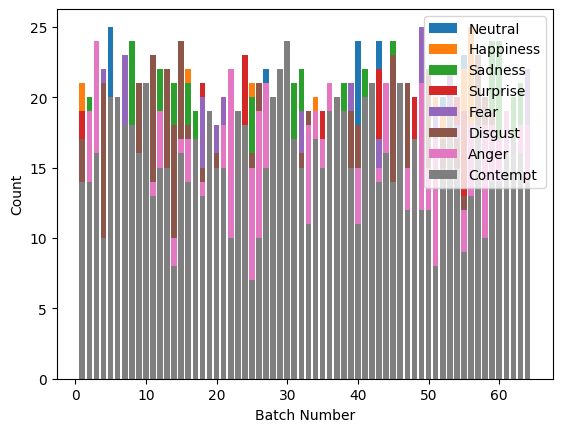

Avg Proportion of Class 0 per batch: 0.127685546875
Avg Proportion of Class 1 per batch: 0.1243896484375
Avg Proportion of Class 2 per batch: 0.1319580078125
Avg Proportion of Class 3 per batch: 0.1207275390625
Avg Proportion of Class 4 per batch: 0.1236572265625
Avg Proportion of Class 5 per batch: 0.128662109375
Avg Proportion of Class 6 per batch: 0.122314453125
Avg Proportion of Class 7 per batch: 0.12060546875
Num. unique images seen: 7769


In [53]:
labels = ["Neutral", "Happiness", "Sadness", "Surprise", "Fear", "Disgust", "Anger",
"Contempt"]
class_batch_counts, idxs_seen = visualise_dataloader(train_loader, labels)

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (16,) and arg 1 with shape (15,).

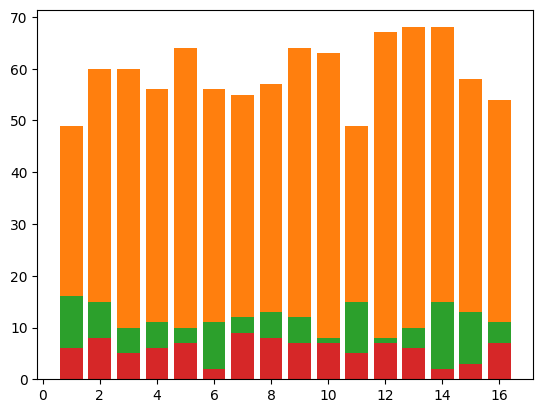

In [61]:
class_batch_counts, idxs_seen = visualise_dataloader(train_loader, labels)

# RandAugment

In [ ]:
rand_n2_m9 = v2.Compose([
    v2.RandAugment(num_ops=2, magnitude=9),
    v2.ToDtype(torch.float32),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

rand_n5_m9 = v2.Compose([
    v2.RandAugment(num_ops=5, magnitude=9),
    v2.ToDtype(torch.float32),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

rand_n2_m16 = v2.Compose([
    v2.RandAugment(num_ops=2, magnitude=16),
    v2.ToDtype(torch.float32),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

rand_n5_m16 = v2.Compose([
    v2.RandAugment(num_ops=5, magnitude=16),
    v2.ToDtype(torch.float32),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
img_path = "/content/test_images/0.jpg"
# Read image
image = read_image(img_path)
image_rand_aug_n2_m9_pil = rand_n2_m9(image)
image_rand_aug_n5_pil = rand_n5_m9(image)
image_rand_aug_m16_pil = rand_n2_m16(image)
image_rand_aug_n5_m16_pil = rand_n5_m16(image)

# To pil
image_pil = v2.functional.to_pil_image(image)
image_rand_aug_n2_m9_pil = v2.functional.to_pil_image(image_rand_aug_n2_m9_pil)
image_rand_aug_n5_pil = v2.functional.to_pil_image(image_rand_aug_n5_pil)
image_rand_aug_m16_pil = v2.functional.to_pil_image(image_rand_aug_m16_pil)
image_rand_aug_n5_m16_pil = v2.functional.to_pil_image(image_rand_aug_n5_m16_pil)

In [ ]:
image_norm = rand_n2_m9 = v2.Compose([
    v2.ToDtype(torch.float32),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
imagen_pil = v2.functional.to_pil_image(image_norm(image))

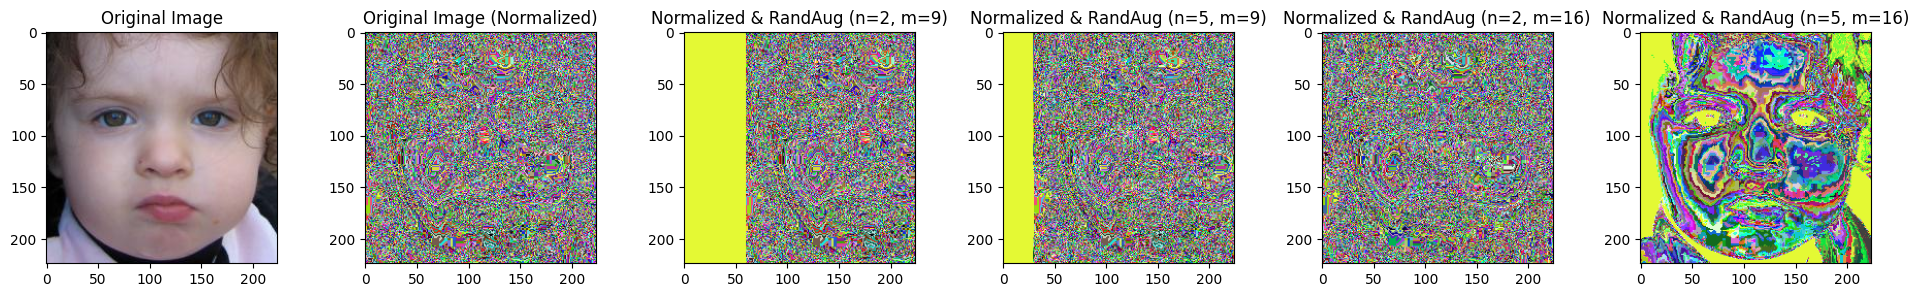

In [ ]:
# Display the images side by side
fig, axs = plt.subplots(1, 6, figsize=(24, 3))

axs[0].imshow(image_pil)
axs[0].set_title('Original Image')

axs[1].imshow(imagen_pil)
axs[1].set_title('Original Image (Normalized)')

axs[2].imshow(image_rand_aug_n2_m9_pil)
axs[2].set_title('Normalized & RandAug (n=2, m=9)')

axs[3].imshow(image_rand_aug_n5_pil)
axs[3].set_title('Normalized & RandAug (n=5, m=9)')

axs[4].imshow(image_rand_aug_m16_pil)
axs[4].set_title('Normalized & RandAug (n=2, m=16)')

axs[5].imshow(image_rand_aug_n5_m16_pil)
axs[5].set_title('Normalized & RandAug (n=5, m=16)')

plt.show()

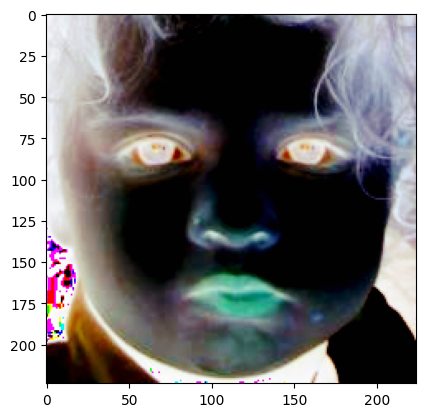

In [ ]:
plt.imshow(image_rand_aug_n5_m16_pil)